#1.Intalling the required packages

In [1]:
#1.Intalling the required packages


In [2]:
! pip install "tweet-preprocessor==0.5.0"
! pip install "seaborn==0.11.2"
! pip install "networkx==2.6.3"
! pip install "transformers==4.18.0"
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

  Using cached tweet-preprocessor-0.5.0.tar.gz (6.3 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for tweet-preprocessor: filename=tweet_preprocessor-0.5.0-py3-none-any.whl size=7927 sha256=9792c65bc766e41a17ac4c85cb85525f97177bdf86a97219dbb9506351f712cc
  Stored in directory: c:\users\duygu\appdata\local\pip\cache\wheels\9c\34\6b\fe4d6092956cc681b053b95dbe2c08f8d924eb559f9eddabb4
Successfully built tweet-preprocessor


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\duygu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\duygu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\duygu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\duygu\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\duygu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\duygu\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-d

True

#Import the libraries to be used 

In [3]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import string
import preprocessor as p
import warnings

import nltk
from nltk import word_tokenize, FreqDist, bigrams, trigrams
from nltk.corpus import stopwords
import nltk; nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow import keras
from transformers import BertTokenizer
from transformers import TFBertModel
from tensorflow.keras.models import model_from_json

plt.style.use("seaborn-darkgrid")
warnings.filterwarnings('ignore')
%matplotlib inline
%config IPCompleter.greedy=True

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\duygu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

#3. let's use now the dataset provided for this exercise 

In [5]:
#loading the data provided, create names for the columns, remember that the delimiter is a tab so you'll have to take into consideration using "\t".
imdb = pd.read_csv('imdb_labelled.txt', names =['Reviews', 'Label'], delimiter="\t", header =None)
imdb.head()

FileNotFoundError: [Errno 2] No such file or directory: 'imdb_labelled.txt'

In [ ]:
#Summary of the dataset by using describe 
imdb.describe()

,Label
count,748.000000
mean,0.516043
std,0.500077
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [ ]:
#code for dropping any duplicate value if exists, if it does not exists it wont do anything to your data so dont worry about it.
imdb.drop_duplicates(subset ="Reviews", keep = "first", inplace = True)
imdb.to_csv('/content/drive/MyDrive/BigdataTasks/Task4 - LDA/Dataset.csv', index=False)
imdb = pd.read_csv('/content/drive/MyDrive/BigdataTasks/Task4 - LDA/Dataset.csv')

new_imdb = imdb
print(new_imdb.shape)
new_imdb.head()

(745, 2)


,Reviews,Label
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


#4. Let's do some preprocesing, for this I will set a bunch of functions to help me clean the data 

In [ ]:
# converting reviews into lower case
def comment_lower(comment):
    return comment.lower()

# removing website links (parts starting with http) from reviews
def remove_links(comment):
    comment = re.sub("https?:\/\/\S+", "", comment)
    return comment

# removing breaks from reviews
def remove_breaks(comment):
    comment = re.sub("", "", comment)
    return comment

# removing numbers
def remove_numbers(comment):
    comment = re.sub(r'\d+', '', str(comment))
    return comment

# removing punctuation from reviews
def remove_punctuation(comment):
    translator = str.maketrans('', '', string.punctuation)
    return comment.translate(translator)

# tokenization of reviews
def tokenize(comment):
    comment = word_tokenize(comment)
    return comment

# removing stopwords from reviews 
stpwrd = nltk.corpus.stopwords.words('english')
new_stopwords = ["movie", "film","Movie", "Film","one","One","Really","really","made","Made","also","Also"]
stpwrd.extend(new_stopwords)
def remove_stopwords(comment):
    comment = [i for i in comment if not i in stpwrd]
    return comment

# lemmatization of reviews
lemmatizer = WordNetLemmatizer()
def lemmatize(comment):
    comment = [lemmatizer.lemmatize(token) for token in comment]
    return comment

def preprocessing(comment):
    comment = comment_lower(comment)
    comment = remove_links(comment)
    comment = remove_breaks(comment)
    comment = remove_numbers(comment)
    comment = remove_punctuation(comment)
    comment = tokenize(comment)
    comment = remove_stopwords(comment)
    comment = lemmatize(comment)
    comment = ' '.join(comment)
    return comment

In [ ]:
#we now are creating a new dataframe where we will add a new column clean reviews, these column will contain all the text already cleaned 
clean_reviews = []
for comment in new_imdb['Reviews']:
    initial_pp_review = p.clean(str(comment))
    preprocessed_review = preprocessing(initial_pp_review)
    clean_reviews.append(preprocessed_review)

new_imdb['clean_review'] = clean_reviews
new_imdb.head()

,Reviews,Label,clean_review
0,"A very, very, very slow-moving, aimless movie ...",0,slowmoving aimless distressed drifting young man
1,Not sure who was more lost - the flat characte...,0,sure lost flat character audience nearly half ...
2,Attempting artiness with black & white and cle...,0,attempting artiness black white clever camera ...
3,Very little music or anything to speak of.,0,little music anything speak
4,The best scene in the movie was when Gerardo i...,1,best scene gerardo trying find song keep runni...


In [ ]:
# saving the Preprocessed Reviews into Original Dataset
df = pd.read_csv('/content/drive/MyDrive/BigdataTasks/Task4 - LDA/Dataset.csv')
df["clean_review"] = new_imdb['clean_review']
df.to_csv('/content/drive/MyDrive/BigdataTasks/Task4 - LDA/Dataset.csv', index=False)
new_imdb = pd.read_csv('/content/drive/MyDrive/BigdataTasks/Task4 - LDA/Dataset.csv')

#5. Now I will use a Token Identification 

In [ ]:
#import the new dataset again and check that everything is working properly 
new_imdb.head()

,Reviews,Label,clean_review
0,"A very, very, very slow-moving, aimless movie ...",0,slowmoving aimless distressed drifting young man
1,Not sure who was more lost - the flat characte...,0,sure lost flat character audience nearly half ...
2,Attempting artiness with black & white and cle...,0,attempting artiness black white clever camera ...
3,Very little music or anything to speak of.,0,little music anything speak
4,The best scene in the movie was when Gerardo i...,1,best scene gerardo trying find song keep runni...


In [ ]:
#create a token 
tokens = []
for comment in new_imdb["clean_review"].astype(str):
 for token in word_tokenize(comment):
        tokens.append(token)

In [ ]:
print(tokens[:20])

['slowmoving', 'aimless', 'distressed', 'drifting', 'young', 'man', 'sure', 'lost', 'flat', 'character', 'audience', 'nearly', 'half', 'walked', 'attempting', 'artiness', 'black', 'white', 'clever', 'camera']


In [ ]:
#here we can print put a distribution of the most common tokens, for this exercise is mostly bad, character and good 
FreqDist(tokens).most_common()[:25]

[('bad', 67),
 ('character', 58),
 ('good', 56),
 ('like', 49),
 ('time', 47),
 ('acting', 41),
 ('great', 40),
 ('even', 39),
 ('see', 36),
 ('scene', 33),
 ('story', 32),
 ('well', 31),
 ('make', 30),
 ('movie', 30),
 ('ever', 29),
 ('actor', 28),
 ('plot', 27),
 ('film', 27),
 ('dont', 26),
 ('best', 25),
 ('thing', 25),
 ('script', 25),
 ('way', 25),
 ('work', 23),
 ('love', 23)]

In [ ]:
fdist = FreqDist(tokens).most_common()[:25]
fdist_dict = dict(fdist)
fdist_dict_sorted = sorted(fdist_dict.items(), key=lambda kv: kv[1], reverse=True)
token, token_counts = list(zip(*fdist_dict_sorted))
token_str = list(map(lambda x: ''.join(x), token))
token_arr = np.array(token_str)
token_counts_arr = np.array(token_counts)

Text(0, 0.5, 'Count')

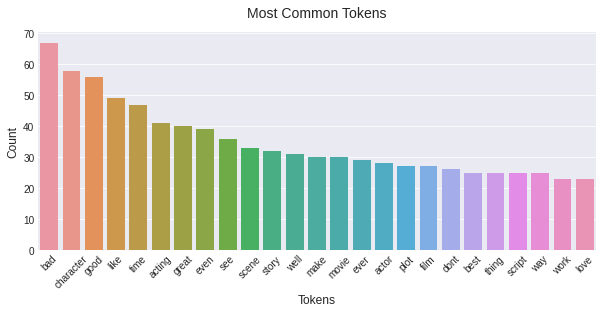

In [ ]:
#plot fot the most common tokens 
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(token_arr, token_counts_arr)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.set_title("Most Common Tokens", fontsize=14, pad=15)
ax.set_xlabel("Tokens", fontsize=12)
ax.set_ylabel("Count", fontsize=12)

#5.1. We can now create a wordcloud from both positive and negative reviews 

In [ ]:
#select only the positive labels
Pos_imdb = new_imdb[new_imdb['Label'] == 1]
Pos_imdb.head()

,Reviews,Label,clean_review
4,The best scene in the movie was when Gerardo i...,1,best scene gerardo trying find song keep runni...
7,Saw the movie today and thought it was a good ...,1,saw today thought good effort good message kid
9,Loved the casting of Jimmy Buffet as the scien...,1,loved casting jimmy buffet science teacher
10,And those baby owls were adorable.,1,baby owl adorable
11,The movie showed a lot of Florida at it's best...,1,showed lot florida best look appealing


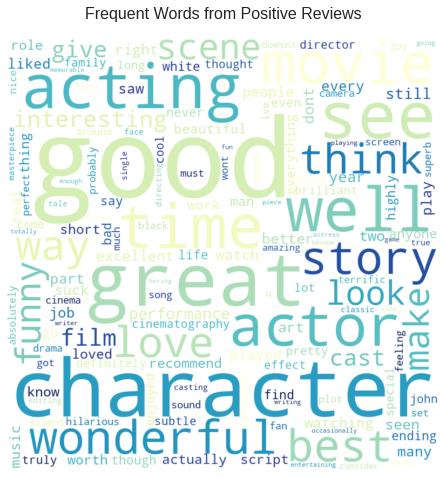

In [ ]:
#create the word cloud 
pos_words = ' '.join(str(review) for review in Pos_imdb['clean_review'])
wordcloud = WordCloud(width = 800, height = 800,
                      colormap = 'YlGnBu',
                      background_color = 'white',
                      min_font_size = 12,
                      max_words = 150,
                      stopwords = STOPWORDS,
                      collocations = False).generate(pos_words) 
                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Frequent Words from Positive Reviews", fontsize=16, pad=20)
plt.show() 

In [ ]:
#do the same for the negative ones 
Neg_imdb = new_imdb[new_imdb['Label'] == 0]
Neg_imdb.head()

,Reviews,Label,clean_review
0,"A very, very, very slow-moving, aimless movie ...",0,slowmoving aimless distressed drifting young man
1,Not sure who was more lost - the flat characte...,0,sure lost flat character audience nearly half ...
2,Attempting artiness with black & white and cle...,0,attempting artiness black white clever camera ...
3,Very little music or anything to speak of.,0,little music anything speak
5,"The rest of the movie lacks art, charm, meanin...",0,rest lack art charm meaning emptiness work gue...


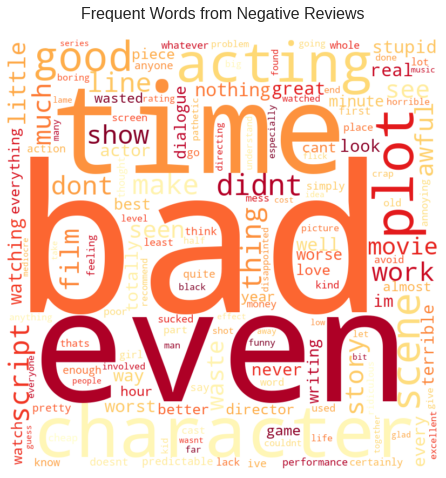

In [ ]:
neg_words = ' '.join(str(review) for review in Neg_imdb['clean_review'])
wordcloud = WordCloud(width = 800, height = 800,
                      colormap = 'YlOrRd',
                      background_color = 'white',
                      min_font_size = 12,
                      max_words = 150,
                      stopwords = STOPWORDS,
                      collocations = False).generate(neg_words) 
                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Frequent Words from Negative Reviews", fontsize=16, pad=20)
plt.show() 

#Biagram/Triagram analysis ( clustering the most frequent word into couples ot trios) easier to identify topics. 

In [ ]:
#biagrams and triagrams give you a much better understanding of the tokens you have created, what it does is basically group the most used tokens into bins of 2 or 3. 
comment_list = []
for comment in new_imdb["clean_review"].astype(str):
    tokens = []
    for token in word_tokenize(comment):
        tokens.append(token)
    comment_list.append(tokens)

In [ ]:
#first the biagram
bigrams_list = []
for comment_tokens in comment_list:
    bigrams_list.extend(list(bigrams(comment_tokens)))

In [ ]:
#frequency to see most biagrams in our tokens
bigrams_freq = Counter(bigrams_list)
bigrams_freq.most_common(25)

[(('waste', 'time'), 11),
 (('ever', 'seen'), 10),
 (('ive', 'ever'), 6),
 (('bad', 'bad'), 5),
 (('story', 'line'), 4),
 (('dont', 'think'), 4),
 (('acting', 'bad'), 4),
 (('movie', 'like'), 4),
 (('ray', 'charles'), 4),
 (('year', 'old'), 4),
 (('dont', 'waste'), 4),
 (('recommend', 'anyone'), 4),
 (('avoid', 'cost'), 4),
 (('black', 'white'), 3),
 (('plot', 'line'), 3),
 (('two', 'hour'), 3),
 (('good', 'actor'), 3),
 (('wind', 'lion'), 3),
 (('hour', 'half'), 3),
 (('great', 'director'), 3),
 (('go', 'see'), 3),
 (('pretty', 'much'), 3),
 (('didnt', 'work'), 3),
 (('anyone', 'could'), 3),
 (('even', 'good'), 3)]

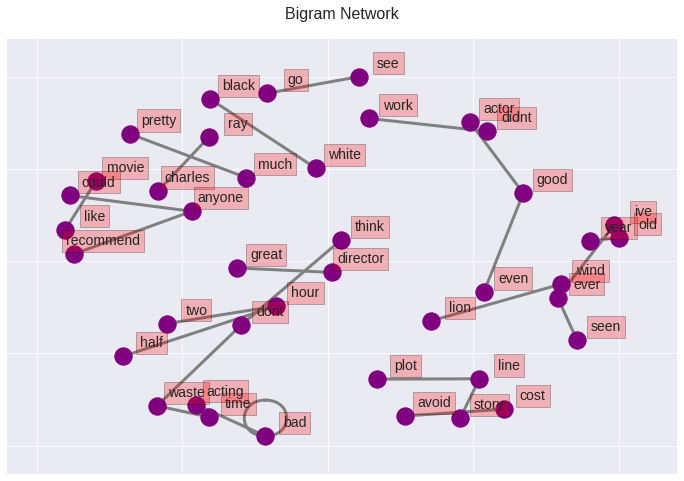

In [ ]:
#lets plot the biagram to cleary see the pair of tokens we get 
G = nx.Graph()
for b, freq in bigrams_freq.most_common(25):
    G.add_edge(b[0], b[1], weight=freq)

plt.subplots(figsize=(12, 8))
pos = nx.spring_layout(G, k=1)

nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color="grey",
                 node_color="purple",
                 with_labels=False)

# create offset labels
for key, value in pos.items():
    x, y = value[0] + 0.1, value[1] + 0.05
    plt.text(x, y, s=key,
             bbox=dict(facecolor="red", alpha=0.25),
             horizontalalignment="center", fontsize=14)
    
plt.title("Bigram Network", fontsize=16, pad=20)
plt.show()

In [ ]:
#do the same fotr trigrams  
trigrams_list = []
for comment_tokens in comment_list:
    trigrams_list.extend(list(trigrams(comment_tokens)))

In [ ]:
trigrams_freq = Counter(trigrams_list)
trigrams_freq.most_common(25)

[(('ive', 'ever', 'seen'), 4),
 (('dont', 'waste', 'time'), 4),
 (('dont', 'think', 'ive'), 2),
 (('think', 'ive', 'ever'), 2),
 (('movie', 'ive', 'ever'), 2),
 (('try', 'make', 'sense'), 2),
 (('every', 'member', 'family'), 2),
 (('show', 'ever', 'seen'), 2),
 (('ever', 'seen', 'entire'), 2),
 (('seen', 'entire', 'life'), 2),
 (('fifteen', 'year', 'old'), 2),
 (('volcano', 'los', 'angeles'), 2),
 (('errol', 'flynn', 'brilliant'), 2),
 (('im', 'big', 'fan'), 2),
 (('film', 'ever', 'seen'), 2),
 (('slowmoving', 'aimless', 'distressed'), 1),
 (('aimless', 'distressed', 'drifting'), 1),
 (('distressed', 'drifting', 'young'), 1),
 (('drifting', 'young', 'man'), 1),
 (('sure', 'lost', 'flat'), 1),
 (('lost', 'flat', 'character'), 1),
 (('flat', 'character', 'audience'), 1),
 (('character', 'audience', 'nearly'), 1),
 (('audience', 'nearly', 'half'), 1),
 (('nearly', 'half', 'walked'), 1)]

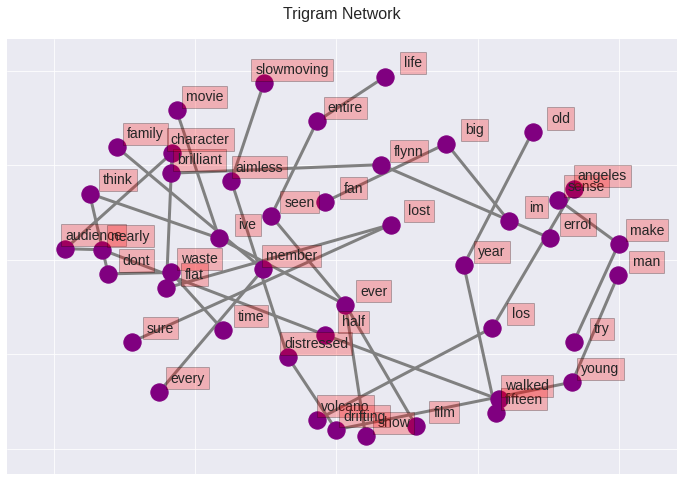

In [ ]:
G = nx.Graph()
for b, freq in trigrams_freq.most_common(25):
    G.add_edge(b[0], b[1], weight=freq)
    G.add_edge(b[1], b[2], weight=freq)

plt.subplots(figsize=(12, 8))
pos = nx.spring_layout(G, k=1)

nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color="grey",
                 node_color="purple",
                 with_labels=False)

# create offset labels
for key, value in pos.items():
    x, y = value[0] + 0.1, value[1] + 0.05
    plt.text(x, y, s=key,
             bbox=dict(facecolor="red", alpha=0.25),
             horizontalalignment="center", fontsize=14)

plt.title("Trigram Network", fontsize=16, pad=20)    
plt.show()


#Now we can start with our LDA Topic modeling

In [ ]:
reviews_for_lda = [" ".join(words) for words in comment_list]
reviews_for_lda[:3]

['slowmoving aimless distressed drifting young man',
 'sure lost flat character audience nearly half walked',
 'attempting artiness black white clever camera angle disappointed became even ridiculous acting poor plot line almost nonexistent']

In [ ]:
#vectorization
tf_vectorizer = CountVectorizer()
tf = tf_vectorizer.fit_transform(reviews_for_lda)
tf_feature_names = tf_vectorizer.get_feature_names()

In [ ]:
#model training 
k = 10
lda_topic_model = LatentDirichletAllocation(n_components=k, random_state=0).fit(tf)
doc_topics = lda_topic_model.transform(tf)

In [ ]:
#let's check the top 10 topics 
no_top_words = 10
for i, topic in enumerate(lda_topic_model.components_):
    print(i, [tf_feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])

0 ['good', 'time', 'film', 'great', 'love', 'worst', 'make', 'actor', 'year', 'see']
1 ['dont', 'time', 'best', 'great', 'think', 'waste', 'real', 'excellent', 'like', 'character']
2 ['script', 'go', 'show', 'acting', 'part', 'time', 'bad', 'good', 'well', 'get']
3 ['bad', 'even', 'acting', 'film', 'could', 'watching', 'well', 'like', 'character', 'nothing']
4 ['story', 'suck', 'character', 'like', 'great', 'ever', 'plot', 'script', 'movie', 'excellent']
5 ['awful', 'keep', 'watch', 'well', 'interesting', 'year', 'end', 'music', 'nothing', 'rating']
6 ['character', 'good', 'every', 'cast', 'much', 'game', 'great', 'make', 'actor', 'say']
7 ['plot', 'thing', 'even', 'acting', 'make', 'worse', 'good', 'come', 'line', 'going']
8 ['like', 'bad', 'character', 'scene', 'funny', 'seen', 'didnt', 'way', 'definitely', 'movie']
9 ['bad', 'scene', 'see', 'time', 'good', 'look', 'get', 'little', 'movie', 'first']


In [ ]:
#topic allocation
doc_topic_index = [doc_topics[i].argmax() for i in range(doc_topics.shape[0])]
doc_topic_index[:5]

[3, 2, 3, 9, 5]

In [ ]:
new_imdb["topic"] = doc_topic_index  # Use the result to add a new column "topic".
new_imdb.head()

,Reviews,Label,clean_review,topic
0,"A very, very, very slow-moving, aimless movie ...",0,slowmoving aimless distressed drifting young man,3
1,Not sure who was more lost - the flat characte...,0,sure lost flat character audience nearly half ...,2
2,Attempting artiness with black & white and cle...,0,attempting artiness black white clever camera ...,3
3,Very little music or anything to speak of.,0,little music anything speak,9
4,The best scene in the movie was when Gerardo i...,1,best scene gerardo trying find song keep runni...,5


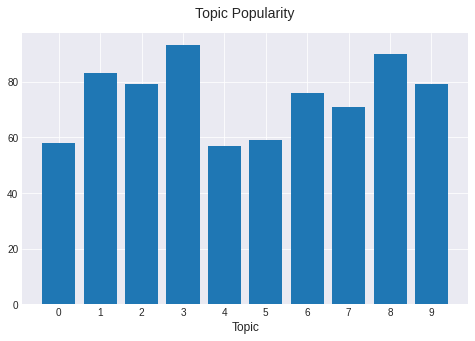

In [ ]:
# Visualization of Topic Popularity
topic_counts = new_imdb["topic"].value_counts().sort_index()

plt.figure(figsize=(8, 5))
plt.bar(topic_counts.index, topic_counts)
plt.title("Topic Popularity", fontsize=14, pad=15)
plt.xlabel("Topic", fontsize = 12)
plt.xticks(range(k))
plt.show()

In [ ]:
#Prepare Final Data
cols = ['Label', 'Reviews']
final_imdb = pd.DataFrame(columns=cols, index=range(len(new_imdb.index)))
final_imdb["Label"] = ""

for i in range(0,len(new_imdb.index)):
    if new_imdb['Label'].iloc[i] == 1:
        final_imdb["Label"].iloc[i] = 1
    else:
        final_imdb["Label"].iloc[i] = 0

final_imdb["Label"] = final_imdb["Label"].astype("float32")
final_imdb["Reviews"] = new_imdb['clean_review']
final_imdb.to_csv('/content/drive/MyDrive/BigdataTasks/Task4 - LDA/FinalImdb.csv', index=False)
final_imdb.head()

,Label,Reviews
0,0.0,slowmoving aimless distressed drifting young man
1,0.0,sure lost flat character audience nearly half ...
2,0.0,attempting artiness black white clever camera ...
3,0.0,little music anything speak
4,1.0,best scene gerardo trying find song keep runni...


In [ ]:
final_imdb['Label'].value_counts()

1.0    384
0.0    361
Name: Label, dtype: int64

In [ ]:
reviews_for_lda = [" ".join(words) for words in comment_list]
reviews_for_lda = [d.split() for d in reviews_for_lda]
reviews_for_lda[:3]

[['slowmoving', 'aimless', 'distressed', 'drifting', 'young', 'man'],
 ['sure', 'lost', 'flat', 'character', 'audience', 'nearly', 'half', 'walked'],
 ['attempting',
  'artiness',
  'black',
  'white',
  'clever',
  'camera',
  'angle',
  'disappointed',
  'became',
  'even',
  'ridiculous',
  'acting',
  'poor',
  'plot',
  'line',
  'almost',
  'nonexistent']]

In [ ]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Create Dictionary
id2word = corpora.Dictionary(reviews_for_lda)

# Create Corpus
texts = reviews_for_lda

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]]


In [ ]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('aimless', 1),
  ('distressed', 1),
  ('drifting', 1),
  ('man', 1),
  ('slowmoving', 1),
  ('young', 1)]]

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=90,
                                           update_every=1,
                                           chunksize=35,
                                           passes=10,
                                           eta='auto',
                                           alpha='auto',
                                           decay=1,
                                           per_word_topics=True)

In [ ]:
# Print the Keyword in the topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.013*"bad" + 0.008*"acting" + 0.008*"character" + 0.007*"see" + 0.007*"like" + 0.007*"even" + 0.007*"good" + 0.006*"time" + 0.006*"plot" + 0.005*"well"'), (1, '0.009*"character" + 0.008*"great" + 0.007*"good" + 0.007*"time" + 0.006*"film" + 0.005*"scene" + 0.005*"story" + 0.005*"bad" + 0.005*"like" + 0.004*"well"'), (2, '0.010*"like" + 0.009*"good" + 0.007*"character" + 0.007*"time" + 0.006*"movie" + 0.005*"story" + 0.005*"make" + 0.005*"ever" + 0.005*"way" + 0.005*"acting"')]


In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=reviews_for_lda, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.599858741532007

Coherence Score:  0.49139958329991545


In [ ]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 4.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=cb4a3c5f451cf649556d8ca7b5f23514b2ead98ad09a6048923d361cf618b598
  Stored in directory: /root/.cache/pip/wheels/90/61/ec/9dbe9efc3acf9c4e37ba70fbbcc3f3a0ebd121060aa593181a
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=6e480bc02d67e68a2e082203c818d10422924bdea497c3d6e100b01968596e95
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built pyLDAvis sklearn


In [ ]:
# Plotting tools
#import pyLDAvis.gensim_models
# Visualize the topics
pyLDAvis.enable_notebook()
fig1 = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
fig1

NameError: ignored

#Guided LDA

In [ ]:
####Guided LDA 

def viz_model(model, modeldict):
    ntopics = model.num_topics
    # top words associated with the resulting topics
    topics = ['Topic {}: {}'.format(t,modeldict[w]) for t in range(ntopics) for w,p in model.get_topic_terms(t, topn=1)]
    terms = [modeldict[w] for w in modeldict.keys()]
    fig,ax=plt.subplots()
    ax.imshow(model.get_topics())  # plot the numpy matrix
    ax.set_xticks(modeldict.keys())  # set up the x-axis
    ax.set_xticklabels(terms, rotation=90)
    ax.set_yticks(np.arange(ntopics))  # set up the y-axis
    ax.set_yticklabels(topics)
    plt.show()

In [ ]:
def test_eta(eta, dictionary, ntopics, print_topics=True, print_dist=True):
    np.random.seed(42) # set the random seed for repeatability
    bow = [dictionary.doc2bow(line) for line in texts] # get the bow-format lines with the set dictionary
    with (np.errstate(divide='ignore')):  # ignore divide-by-zero warnings
        model = gensim.models.ldamodel.LdaModel(
            corpus=bow, id2word=dictionary, num_topics=ntopics,
            random_state=42, chunksize=100, eta=eta,
            eval_every=-1, update_every=1,
            passes=150, alpha='auto', per_word_topics=True)
    # visuzlize the model term topics
    viz_model(model, dictionary)
    print('Perplexity: {:.2f}'.format(model.log_perplexity(bow)))
    if print_topics:
        # display the top terms for each topic
        for topic in range(ntopics):
            print('Topic {}: {}'.format(topic, [dictionary[w] for w,p in model.get_topic_terms(topic, topn=3)]))
    if print_dist:
        # display the topic probabilities for each document
        for line,bag in zip(df['Reviews'],bow):
            doc_topics = ['({}, {:.1%})'.format(topic, prob) for topic,prob in model.get_document_topics(bag)]
            print('{} {}'.format(line, doc_topics))
    return model

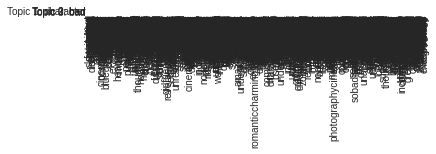

Perplexity: -7.51
Topic 0: ['bad', 'character', 'good']
Topic 1: ['character', 'bad', 'good']
Topic 2: ['bad', 'character', 'good']
Topic 3: ['bad', 'character', 'good']
A very, very, very slow-moving, aimless movie about a distressed, drifting young man.   ['(1, 99.8%)']
Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out.   ['(3, 99.9%)']
Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent.   ['(1, 99.9%)']
Very little music or anything to speak of.   ['(2, 99.8%)']
The best scene in the movie was when Gerardo is trying to find a song that keeps running through his head.   ['(0, 99.9%)']
The rest of the movie lacks art, charm, meaning... If it's about emptiness, it works I guess because it's empty.   ['(0, 99.9%)']
Wasted two hours.   ['(3, 99.7%)']
Saw the movie today and thought it was a good effort, good 

In [ ]:
test_eta('auto',id2word,ntopics=4)

In [ ]:
def create_eta(priors, etadict, ntopics):
    eta = np.full(shape=(ntopics, len(etadict)), fill_value=1) # create a (ntopics, nterms) matrix and fill with 1
    for word, topic in priors.items(): # for each word in the list of priors
        keyindex = [index for index,term in etadict.items() if term==word] # look up the word in the dictionary
        if (len(keyindex)>0): # if it's in the dictionary
            eta[topic,keyindex[0]] = 1e7  # put a large number in there
    eta = np.divide(eta, eta.sum(axis=0)) # normalize so that the probabilities sum to 1 over all topics
    return eta

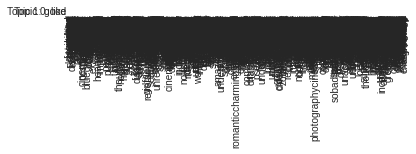

Perplexity: -4.72
Topic 0: ['like', 'time', 'bad']
Topic 1: ['good', 'character', 'great']
A very, very, very slow-moving, aimless movie about a distressed, drifting young man.   ['(1, 99.1%)']
Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out.   ['(1, 99.3%)']
Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent.   ['(1, 99.7%)']
Very little music or anything to speak of.   ['(0, 98.4%)', '(1, 1.6%)']
The best scene in the movie was when Gerardo is trying to find a song that keeps running through his head.   ['(1, 99.4%)']
The rest of the movie lacks art, charm, meaning... If it's about emptiness, it works I guess because it's empty.   ['(1, 99.4%)']
Wasted two hours.   ['(0, 97.9%)', '(1, 2.1%)']
Saw the movie today and thought it was a good effort, good messages for kids.   ['(1, 99.3%)']
A bit predictable

In [ ]:
apriori_original = {
    'bad':0, 'awful':0, 'suck':0, 'waste':0, 'embarrassing':0, 'predictable':0, 'disaster':0, 'recommend':0, 'wont':0, 'dont':0,
    'good':1, 'love':1, 'great':1, 'wonderful':1,'funny':1, 'pleasant':1, 'excellent':1, 'recommend':1, 'would':1
}
eta = create_eta(apriori_original, id2word, 2)
test_eta(eta, id2word, 2)

In [ ]:
!pip install nbconvert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!jupyter nbconvert --to html Task4 - Unguided & Guided LDA.ipynb

/bin/bash: Guided: command not found
[NbConvertApp] WARNING | pattern 'Task4' matched no files
[NbConvertApp] WARNING | pattern '-' matched no files
[NbConvertApp] WARNING | pattern 'Unguided' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.ge